In [1]:
%load_ext autoreload
%autoreload 2

## Generate Data

In [ ]:
from generate_data import gen_icnn_training_data, ILQR, unicycle, save_object, unicycle_K
import jax.numpy as onp

# F = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [0, 1]])
# Kp = 5 * np.array([[2, 1, 0], [0, 1, 3]])
# Kd = np.linalg.pinv(F)

uni_ilqr1 = ILQR(unicycle_K, maxiter=1000)
num_iter = 70
xtraj, poly_traj, rtraj, rdottraj, costs = gen_icnn_training_data(uni_ilqr1, num_iter, 6, 3)

# Save as pickle file
save_object([xtraj, poly_traj, rtraj, rdottraj, costs], 'data/icnn_train-2.pkl')

/home/anusha/.local/lib/python3.8/site-packages/jax/_src/api_util.py:165: SyntaxWarning: Jitted function has static_argnums=(0, 1, 9), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


[2.5280728 2.9722507 1.4306502 1.6425164 2.577362  2.6530364 1.2016213
 1.2029116 2.1599755 2.6883261 2.3371816 1.3628914 1.4776299 1.7921913
 2.1458519 2.673093  2.5027437 1.5062327 1.359015  1.7737467 1.0348337
 1.944695  2.0857658 1.4919887 2.933309  2.1067882 2.0550287 1.8880596
 2.6056852 2.076088  1.276299  2.6491048 2.8133643 1.227606  1.4221973
 2.18872   1.3594167 1.0053928 2.3214507 2.754931  1.4893377 2.450339
 1.5379288 2.5451531 2.0928957 2.9777732 1.7261112 1.029901  2.2062783
 1.5908973 1.0997066 1.3382993 2.6472833 2.5792866 1.6459436 1.9612389
 2.8218193 1.6256263 1.2985592 1.0225728 1.4330561 2.9151683 2.0037787
 2.2296891 1.5238268 1.4741652 1.5785863 1.8881533 1.9573283 1.0925453
 2.3067627 2.0327501 2.379015  1.3423629 1.2943757 1.4743266 1.8865693
 2.4094245 2.8154771 2.9507406 2.6964977 1.9009523 2.6339543 2.0082576
 1.3210547 1.7792075 1.8351984 2.3418221 2.0228674 1.9526393 2.8989007
 2.2786968 1.1645913 1.3434968 2.3182673 2.2182777 2.70424   1.7579925
 2.6252

/home/anusha/.local/lib/python3.8/site-packages/trajax/tvlqr.py:98: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  K = -sp.linalg.solve(G_, H, sym_pos=True)
/home/anusha/.local/lib/python3.8/site-packages/trajax/tvlqr.py:99: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  k = -sp.linalg.solve(G_, h, sym_pos=True)


In [12]:
%reload_ext autoreload

## Load data

In [2]:
from helper_functions import compute_tracking_cost
from picnn_jax import PICNN
from generate_data import load_object, save_object
from model_learning import ICNNTrajDataset
from model_learning import train_model, eval_model, numpy_collate, save_checkpoint, restore_checkpoint
#from bn_model_learning import bn_train_model, bn_eval_model, numpy_collate, save_checkpoint, restore_checkpoint
import numpy as np


file_path = r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/icnn_train-2.pkl"
unicycle_data = load_object(file_path)

actual_traj = np.vstack(unicycle_data[0])
poly_traj = np.vstack(unicycle_data[1])
ref_traj = np.vstack(unicycle_data[2])
rdot_traj = np.vstack(unicycle_data[3])
print(actual_traj.shape)
print(poly_traj.shape)
print(ref_traj.shape)
print(rdot_traj.shape)

/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anusha/.local/lib/python3.8/site-packages/jax/_src/api_util.py:165: SyntaxWarning: Jitted function has static_argnums=(0, 1, 9), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
2023-06-08 10:17:30.989439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anusha/Research/ws_kr/devel/lib:/opt/ros/noetic/lib
2023-06-08 10:17:30.989488: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

(770, 3)
(770, 3)
(770, 3)
(770, 3)


## Visualize trajectories

In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


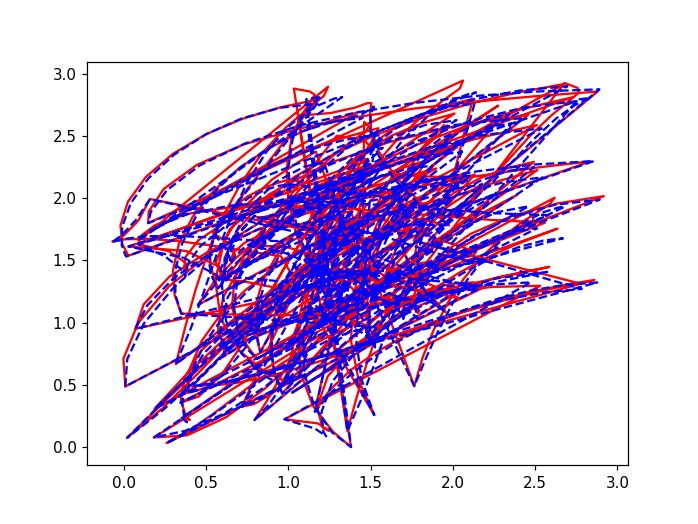

In [4]:
import matplotlib.pyplot as plt

plt.figure()
Tstart = 0
Tend = 770


plt.plot(ref_traj[Tstart:Tend, 0], ref_traj[Tstart:Tend, 1], 'r-', 
         actual_traj[Tstart:Tend, 0], actual_traj[Tstart:Tend, 1], 'b--')

## Prepare data with augmented states and compute cost

In [5]:
import jax

N = 10
q = 2
p = 3 + 3*N
traj_len = ref_traj.shape[0]
horizon = 11
num_iter = int(traj_len/horizon)
# num_iter = 50

# ref_chunks = np.vstack([ref_traj[i*100+5:(i+1)*100-5, :] for i in range(0, len(ref_traj))])
# actual_chunks = np.vstack([actual_traj[i*101+5:(i+1)*101-6, :] for i in range(0, len(actual_traj))])

# Kp = 50 * np.array([[2, 0, 0], [0, 1, 0]])
Kp = 5 * np.array([[2, 1, 0], [0, 1, 3]])
# key = jax.random.PRNGKey(793)
# Kd = 50 * jax.random.uniform(key=key, shape=(2, 3))

del_traj = ref_traj - poly_traj
actual_traj = []

## This is wrong. Need to recompute the actual traj since there is now deviation also

for idx in range(num_iter):
    new_ref = ref_traj[idx*horizon:(idx+1)*horizon, :] + del_traj[idx*horizon:(idx+1)*horizon, :]
    _, act = forward_simulate(new_ref[0, :], new_ref, N)
    actual_traj.append(act)

actual_traj = np.vstack(actual_traj)

cost_traj, input_traj = compute_tracking_cost(ref_traj+del_traj, actual_traj, rdot_traj, Kp, N, horizon, 0.5)

## Testing convex cost

#cost_traj = np.ones(cost_traj.shape)

aug_state = []
del_state = []
for i in range(num_iter):
    r0 = ref_traj[i*horizon:(i+1)*horizon, :]
    r0 = np.append(r0, r0[-1, :] * np.ones((N-1, 3)))
    r0 = np.reshape(r0, (horizon+N-1, 3))
    for j in range(horizon-N):
        z = np.vstack([actual_traj[j, :], r0[j:j+N, :]])
        print(z.shape)
        aug_state.append(np.append(actual_traj[j, :], r0[j:j+N, :]))
        del_state.append(del_traj[j:j+N, :].ravel())
        # aug_state.append(np.append(del_traj[j:j+N, :], z))
        print(aug_state[0].shape)
# aug_state = [np.append(actual_traj[r, :], ref_traj[r:r+N, :]) for r in range(num_iter)]
aug_state = np.array(aug_state)
del_state = np.array(del_state)
print(aug_state.shape)
print(del_state.shape)

Tstart=0
Tend=aug_state.shape[0]

dataset = ICNNTrajDataset(del_state[Tstart:Tend-1, :], aug_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend-1, None].astype('float64'), aug_state[Tstart+1:Tend, :].astype('float64'))

70
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(70, 33)
(70, 30)

<IPython.core.display.Javascript object>


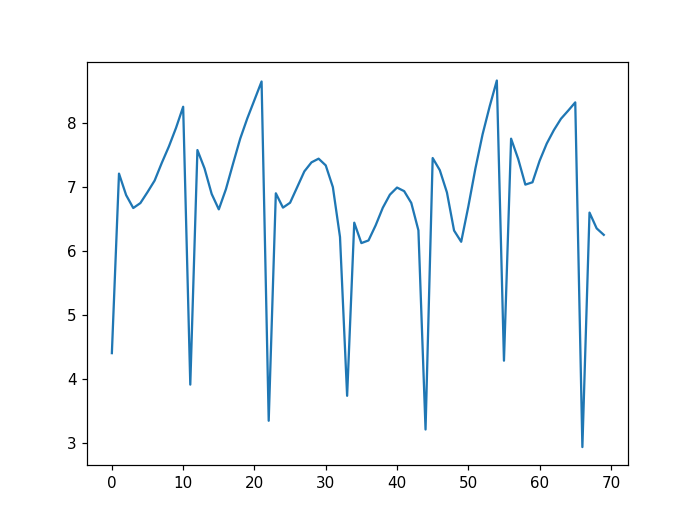

In [6]:
plt.figure()
plt.plot(cost_traj)

## Load model params

In [7]:
# Load model parameters using yaml file
import ruamel.yaml as yaml

with open(r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/params.yaml") as f:
        yaml_data = yaml.load(f, Loader=yaml.RoundTripLoader)

num_hidden = yaml_data['num_hidden']
batch_size = yaml_data['batch_size']
learning_rate = yaml_data['learning_rate']
num_epochs = yaml_data['num_epochs']
model_save = yaml_data['save_path']

In [8]:
batch_size = 8

rng = jax.random.PRNGKey(427)
model = PICNN(num_hidden_nc=[1000, 1000], num_hidden_c=[1000, 1000], num_outputs=1, input_features_nc=p, 
             input_features_c=p-3, seed=rng)
print(model)

PICNN(
    # attributes
    num_hidden_nc = [1000, 1000]
    num_hidden_c = [1000, 1000]
    num_outputs = 1
    input_features_nc = 33
    input_features_c = 30
    seed = DeviceArray([  0, 427], dtype=uint32)
)


In [8]:
import jax.numpy as jnp

rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp_c = jax.random.normal(inp_rng, (batch_size, p-3))  # Batch size 32, input size p
inp_nc = jax.random.normal(inp_rng, (batch_size, p))
# Initialize the model
variables = model.init(init_rng, inp_nc, inp_c, train=False)
params = variables['params']
batch_stats = variables['batch_stats']
jax.tree_util.tree_map(jnp.shape, variables)
y, new_batch_stats = model.apply({'params':params, 'batch_stats':batch_stats}, inp_nc, inp_c, train=True, mutable=['batch_stats'])
print(variables)
batch_stats = new_batch_stats['batch_stats']

TypeError: __call__() got an unexpected keyword argument 'train'

In [10]:
batch_size = 2

rng = jax.random.PRNGKey(427)
model = ICNN(num_hidden_nc=[200, 200], num_hidden_c=[200, 200, 100], num_outputs=1, input_features_nc=p, 
             input_features_c=p-3, seed=rng)
# Printing the model shows its attributes
#Weights_n_B= Initialize_W_B([200, 200, 1], p, p-3, rng)
print(model)

NameError: name 'ICNN' is not defined

In [9]:
# How to do batches here?

rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp_c = jax.random.normal(inp_rng, (batch_size, p-3))  # Batch size 32, input size p
inp_nc = jax.random.normal(inp_rng, (batch_size, p))
# Initialize the model
params = model.init(init_rng, inp_nc, inp_c)
print(params)

FrozenDict({
    params: {
        layer_c: [[0.0, 0.0, DeviceArray([[-2.40681022e-02, -4.47324943e-03, -1.92519277e-02,
                      -7.37238768e-03, -6.85970020e-03, -2.07638759e-02,
                       5.12293214e-03,  3.31980325e-02,  7.88750686e-03,
                      -3.16009447e-02, -2.29931045e-02,  1.78775322e-02,
                       1.20950146e-02,  1.00346410e-03,  1.80114992e-02,
                       1.62875652e-02,  1.04735699e-03,  2.75664348e-02,
                       4.55292873e-03, -4.76808567e-03,  2.49383785e-02,
                      -2.94300970e-02,  2.92786211e-02, -1.57576415e-03,
                      -3.19576189e-02,  1.72356293e-02,  2.25119442e-02,
                       2.50875093e-02, -1.25665199e-02, -1.52900144e-02,
                      -6.87710475e-03, -2.43660137e-02, -2.13008020e-02],
                     [ 1.90033689e-02, -8.24662857e-03,  2.95193996e-02,
                      -9.62691382e-03,  2.04668846e-02,  1.88426990e-02,
  

In [10]:
model.apply(params, inp_nc, inp_c)

DeviceArray([[ 1.7146937 , -0.3064632 ,  7.2665157 , -0.43362978,
              -2.0471847 ,  0.41588724,  2.4922872 , -7.5220666 ]],            dtype=float32)

In [11]:
import optax # Run previous cell if optax not found
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.adam(learning_rate=learning_rate)

In [10]:
from flax.training import train_state

class TrainState(train_state.TrainState):
      batch_stats: dict

model_state = TrainState.create(apply_fn=model.apply, params=params, batch_stats=batch_stats,tx=optimizer)

In [12]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [13]:
import torch.utils.data as data
#from model_learning import train_model

train_data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
trained_model_state = train_model(model_state, train_data_loader, num_epochs=500)

  0%|                                                   | 0/500 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>


100%|█████████████████████████████████████████| 500/500 [01:20<00:00,  6.20it/s]


In [14]:
eval_model(trained_model_state, train_data_loader, 1)

Loss of the model: 0.04


In [14]:
print(trained_model_state.params)

FrozenDict({
    params: {
        layer_c: [[DeviceArray(0., dtype=float32), DeviceArray(0., dtype=float32), DeviceArray([[-0.02130109, -0.0018676 , -0.0163173 , -0.00612837,
                      -0.00422633, -0.01908323,  0.0067501 ,  0.0358081 ,
                       0.00958057, -0.02963746, -0.02038445,  0.01955295,
                       0.01433627,  0.00362749,  0.01963875,  0.01876148,
                       0.00371717,  0.02912472,  0.00724099, -0.00202601,
                       0.02642108, -0.02653695,  0.03210404, -0.00017054,
                      -0.02887028,  0.02014071,  0.02382181,  0.02835194,
                      -0.00959574, -0.01413657, -0.00346293, -0.021349  ,
                      -0.02044525],
                     [ 0.01402228, -0.01232799,  0.02325504, -0.01299151,
                       0.01644635,  0.01390207, -0.00740404,  0.0125424 ,
                       0.01874741, -0.00129704, -0.03306292,  0.02100703,
                      -0.00432461, -0.03291818, 

## Save model

In [17]:
save_checkpoint(trained_model_state, model_save, 4)

InvalidCheckpointError: Trying to save an outdated checkpoint at step: "4" and path: "/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/models/rho100/checkpoint_4". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.InvalidCheckpointError)

## Load model

In [ ]:
trained_model_state = restore_checkpoint(model_state, model_save)

In [13]:
trained_model = model.bind({'params': trained_model_state.params, 'batch_stats': trained_model_state.batch_stats})

In [15]:
trained_model = model.bind(trained_model_state.params)

## Inference

## Load inference data

In [18]:
import numpy as np

file_path = r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/icnn_train.pkl"
unicycle_data = load_object(file_path)

actual_traj = np.vstack(unicycle_data[0])
poly_traj = np.vstack(unicycle_data[1])
ref_traj = np.vstack(unicycle_data[2])
rdot_traj = np.vstack(unicycle_data[3])
print(actual_traj.shape)
print(poly_traj.shape)
print(ref_traj.shape)
print(rdot_traj.shape)

(77, 3)
(77, 3)
(77, 3)
(77, 3)


7
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(11, 3)
(33,)
(7, 33)
(7, 30)
Loss of the model: 2.79


<IPython.core.display.Javascript object>


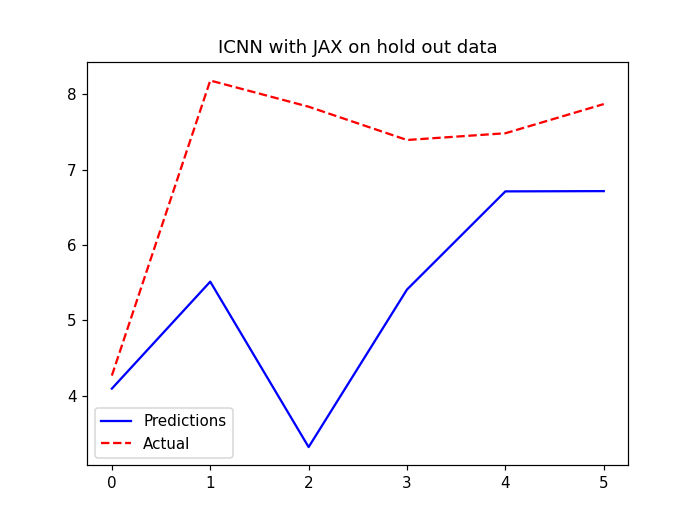

Text(0.5, 1.0, 'ICNN with JAX on hold out data')

In [19]:
import jax
import matplotlib.pyplot as plt

N = 10
q = 2
p = 3 + 3*N
traj_len = ref_traj.shape[0]
horizon = 11
num_iter = int(traj_len/horizon)
# num_iter = 50

# ref_chunks = np.vstack([ref_traj[i*100+5:(i+1)*100-5, :] for i in range(0, len(ref_traj))])
# actual_chunks = np.vstack([actual_traj[i*101+5:(i+1)*101-6, :] for i in range(0, len(actual_traj))])

# Kp = 50 * np.array([[2, 0, 0], [0, 1, 0]])
Kp = 5 * np.array([[2, 1, 0], [0, 1, 3]])
# key = jax.random.PRNGKey(793)
# Kd = 50 * jax.random.uniform(key=key, shape=(2, 3))

del_traj = ref_traj - poly_traj

cost_traj, input_traj = compute_tracking_cost(ref_traj+del_traj, actual_traj, rdot_traj, Kp, N, horizon, 0.5)



aug_test_state = []
del_test_state = []
for i in range(num_iter):
    r0 = ref_traj[i*horizon:(i+1)*horizon, :]
    r0 = np.append(r0, r0[-1, :] * np.ones((N-1, 3)))
    r0 = np.reshape(r0, (horizon+N-1, 3))
    for j in range(horizon-N):
        z = np.vstack([actual_traj[j, :], r0[j:j+N, :]])
        print(z.shape)
        aug_test_state.append(np.append(actual_traj[j, :], r0[j:j+N, :]))
        del_test_state.append(del_traj[j:j+N, :].ravel())
        # aug_state.append(np.append(del_traj[j:j+N, :], z))
        print(aug_test_state[0].shape)
# aug_state = [np.append(actual_traj[r, :], ref_traj[r:r+N, :]) for r in range(num_iter)]
aug_test_state = np.array(aug_test_state)
del_test_state = np.array(del_test_state)
print(aug_test_state.shape)
print(del_test_state.shape)

Tstart=0
Tend=aug_test_state.shape[0]

test_dataset = ICNNTrajDataset(del_test_state[Tstart:Tend-1, :], aug_test_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend, None].astype('float64'), aug_test_state[Tstart+1:Tend, :].astype('float64'))

test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)
eval_model(trained_model_state, test_data_loader, batch_size)

data_input_c, data_input_nc, _, cost, _ = next(iter(test_data_loader))
out = trained_model(data_input_nc, data_input_c) 
#out = trained_model(data_input_nc, data_input_c, False)  # No explicit parameter passing necessary anymore
plt.figure()
plt.plot(out.ravel(), 'b-', label="Predictions")
plt.plot(cost.ravel(), 'r--', label="Actual")
plt.legend()
plt.title("ICNN with JAX on hold out data")

In [27]:
out = []
true = []
for batch in train_data_loader:
    data_input_nc, data_input_c, _, cost, _ = batch
    #out.append(trained_model(data_input_c, data_input_nc, False))
    out.append(trained_model(data_input_c, data_input_nc))
    true.append(cost)

In [28]:
#print(out[13])
#out[13] = -1*np.ones(5)

out = np.vstack(out[:-1])
true = np.vstack(true[:-1])

<IPython.core.display.Javascript object>


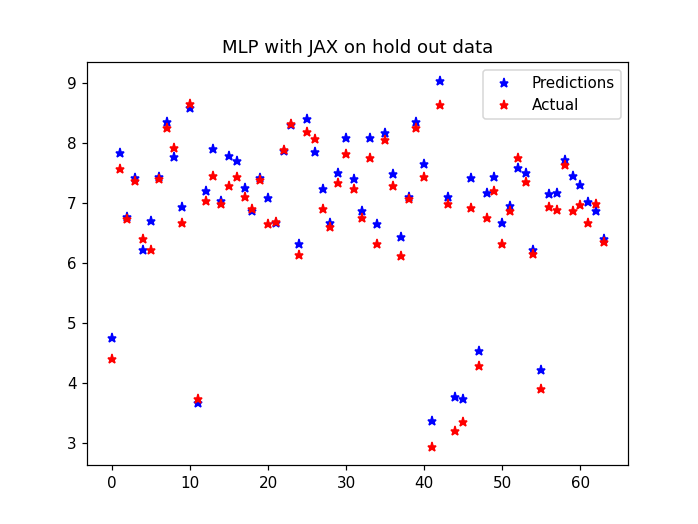

Text(0.5, 1.0, 'MLP with JAX on hold out data')

In [29]:
plt.figure()
plt.plot(out.ravel(), 'b*', label="Predictions")
plt.plot(true.ravel(), 'r*', label="Actual")
plt.legend()
plt.title("MLP with JAX on hold out data")

## Test model

In [38]:
from model_learning import gradient_descent, calculate_cost, gradient_descent_with_line_search
from jax.scipy.optimize import minimize
from jaxopt import LBFGS
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_affine_set
import numpy as np
from functools import partial
import jax.numpy as jnp

from model_learning import gradient_descent, calculate_cost, gradient_descent_with_line_search
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_affine_set
import numpy as np
from functools import partial
import jax.numpy as jnp


@jax.jit
def calc_cost_GD(init_ref, del_ref):
    ref = jnp.zeros(init_ref.shape)
    ref.at[0:3].set(init_ref[0:3])
    ref.at[3:].set(init_ref[3:] + del_ref)
    pred = trained_model(init_ref, del_ref).ravel()
    #print(jnp.exp(pred[0]))
    return 1e-9 * jnp.exp(pred[0])


pg = ProjectedGradient(calc_cost_GD, projection=projection_affine_set)
A = np.zeros((6, (N+1)*3-3))
A[0, 0] = 1
A[1, 1] = 1
A[2, 2] = 1
A[-3, -3] = 1
A[-2, -2] = 1
A[-1, -1] = 1


solution = []
solution2 = []
for i in range(2):
    GD = LBFGS(calc_cost_GD)
    solution2.append(GD.run(aug_test_state[i, :], del_test_state[i, :]))
    
    init = aug_test_state[i, 0:3]
    goal = aug_test_state[i, -3:]
    b = np.append(init, goal)
    
    init_ref = aug_test_state[i, :].copy()
    
    pg = ProjectedGradient(partial(calc_cost_GD, init_ref), projection=projection_affine_set, maxiter=10)
    solution.append(pg.run(del_test_state[i, :], hyperparams_proj=(A, b)))
    
    
    
    
    

KeyboardInterrupt: 

In [ ]:
print(solution[0].params.shape)

<IPython.core.display.Javascript object>


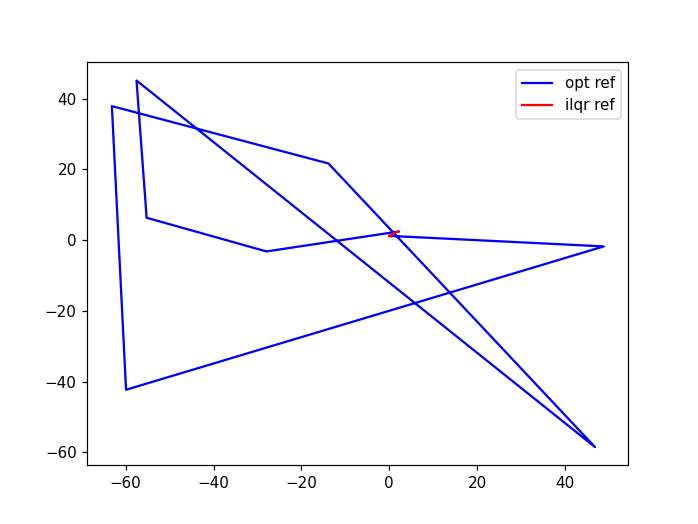

In [35]:
plt.figure()

for i in range(1):
    plt.plot(solution[i].params[0::3], solution[i].params[1::3], 'b-', label='opt ref')
    #plt.plot(ref[i][:, 0], ref[i][:, 1], 'g-', label='opt2')
    #plt.plot(poly_traj[i][:, 0], poly_traj[i][:, 1], 'r--')
    plt.plot(aug_test_state[i, 0::3], aug_test_state[i, 1::3], 'r-', label='ilqr ref')
    plt.legend()

In [76]:
from generate_data import forward_simulate

sim_cost = []
ilqr_cost = []
reg_cost = []
rollout = []
ref = []

N=10

i = 0
for sol in solution:
    #print(sol)
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    reg_cost.append(sol.state.error)
    # print(reg_cost)
    new_aug_state = sol.params
    x0 = new_aug_state[0:3]
    #print("init", x0)
    ref.append(new_aug_state[3:].reshape([N, 3]))
    #print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], N)
    sim_cost.append(c)
    rollout.append(x)
    x0 = aug_test_state[i, 0:3]
    ci, xi = forward_simulate(x0, aug_test_state[i, 3:].reshape([N,3]), N)
    #c_ilqr = np.exp(cost_traj[i][0])
    print(ci)
    ilqr_cost.append(ci)
    #c_poly, x_poly = forward_simulate(x0, poly_traj[i], N)
    #poly_cost.append(c_poly)
    #print("rollout", x)
    i += 1
    

print(np.mean(ilqr_cost))
print(np.mean(reg_cost))
print(np.mean(sim_cost))
plt.figure()
plt.plot(ilqr_cost, '*', label="ilqr cost")
plt.plot(reg_cost, 'o', label="optimized cost")
plt.plot(sim_cost, 'og', label="simulated cost")
plt.legend()

InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes (27,) and (10, 3)

## Test PICNN with simple nonlinear (convex) functions

In [2]:
## Standard libraries
import os
import math
import numpy as np 
import jax.numpy as jnp
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

/tmp/ipykernel_44034/591758026.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
import torch.utils.data as data

class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [4]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), 1)


In [5]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

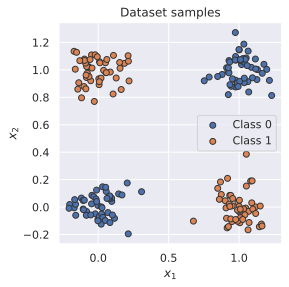

In [6]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [7]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [8]:
import optax
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=0.1)

In [12]:
import jax
from icnn_jax import ICNN

rng = jax.random.PRNGKey(427)
model = ICNN(num_hidden_nc=[200, 200], num_hidden_c=[200, 200, 100], num_outputs=1, input_features_nc=2, 
             input_features_c=2, seed=rng)
# Printing the model shows its attributes
#Weights_n_B= Initialize_W_B([200, 200, 1], p, p-3, rng)
print(model)

ICNN(
    # attributes
    num_hidden_nc = [200, 200]
    num_hidden_c = [200, 200, 100]
    num_outputs = 1
    input_features_nc = 2
    input_features_c = 2
    seed = DeviceArray([  0, 427], dtype=uint32)
)


In [14]:
# How to do batches here?

rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp_c = jax.random.normal(inp_rng, (128, 2))  # Batch size 32, input size p
inp_nc = jax.numpy.zeros((128, 2))
# Initialize the model
print(inp_nc.shape)
params = model.init(init_rng, inp_c, inp_nc.T)
print(params)

(128, 2)
FrozenDict({
    params: {
        layer_c: [[DeviceArray([[-0.14969492,  0.11085629, -0.1469729 ,  0.02531409,
                      -0.902442  ,  0.6965265 , -0.40919256, -0.6897993 ,
                       0.9471998 ,  0.5452571 , -0.02235651, -0.38243294,
                       0.38474798, -0.05421162,  0.703151  ,  0.5354793 ,
                       0.40333056, -0.8008337 ,  0.6375923 ,  0.07423091,
                      -0.6515565 , -0.3454671 , -0.08380771,  0.75579333,
                       0.48296094,  0.8316188 , -0.9893055 , -0.90745544,
                      -0.7494297 ,  0.5586195 , -0.5097866 ,  0.1378715 ,
                      -0.874105  , -0.18913198,  0.07263303, -0.5944078 ,
                      -0.7398739 , -0.04298687, -0.9140301 ,  0.21804357,
                       0.97339344, -0.5168171 , -0.638288  ,  0.6068666 ,
                       0.3827169 , -0.5273514 ,  0.5377009 ,  0.7846377 ,
                      -0.37328243,  0.24962258,  0.06524563,  0.7

In [15]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [28]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    print(data_input.shape)
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, np.zeros(data_input.shape), data_input.T).T.squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

In [29]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

In [30]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

In [31]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [32]:
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [33]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

(128, 2)
(68, 2)


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.08it/s]


In [42]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, 
                                   batch_size=128, 
                                   shuffle=False, 
                                   drop_last=False, 
                                   collate_fn=numpy_collate) 

In [43]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [44]:
eval_model(trained_model_state, test_data_loader)

(1, 2)
Accuracy of the model: 0.00%


In [45]:
trained_model = model.bind(trained_model_state.params)

(200, 200, 2)


TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (200,).

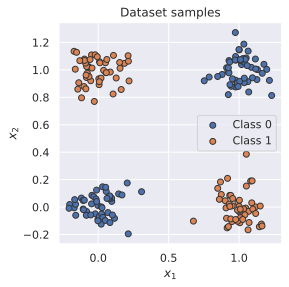

In [46]:
from flax import linen as nn

def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    print(model_inputs.shape)
    logits = model(np.zeros(model_inputs.shape), model_inputs.T)
    preds = nn.sigmoid(logits)
    print(preds.shape)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()

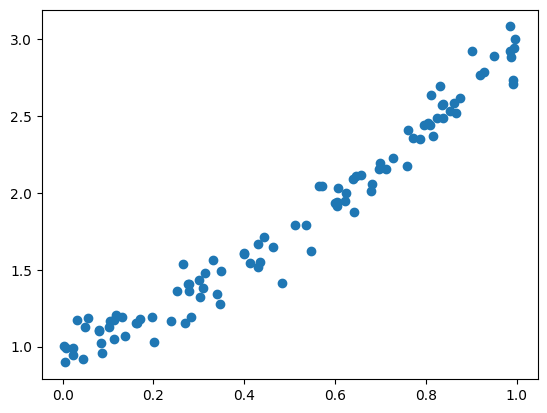

In [18]:
# Generate data from a quadratic function with random noise e
def make_data(n):
  x = np.random.uniform(size=(n,1))
  e = np.random.normal(0, 0.1, size=x.shape)
  y = np.square(x) + x + 1 + e
  return (x,y)

x,y = make_data(100)
fig, ax = plt.subplots(dpi=100)
plt.scatter(x,y.ravel())

In [24]:
# Load model parameters using yaml file
import ruamel.yaml as yaml

with open(r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/params.yaml") as f:
        yaml_data = yaml.load(f, Loader=yaml.RoundTripLoader)

num_hidden = yaml_data['num_hidden']
batch_size = yaml_data['batch_size']
learning_rate = yaml_data['learning_rate']
num_epochs = yaml_data['num_epochs']
model_save = yaml_data['save_path']

In [30]:
batch_size = 64

rng = jax.random.PRNGKey(427)
model = ICNN(num_hidden_nc=[200, 200], num_hidden_c=[200, 200, 100], num_outputs=1, input_features_nc=1, 
             input_features_c=1, seed=rng)
# Printing the model shows its attributes
#Weights_n_B= Initialize_W_B([200, 200, 1], p, p-3, rng)
print(model)

ICNN(
    # attributes
    num_hidden_nc = [200, 200]
    num_hidden_c = [200, 200, 100]
    num_outputs = 1
    input_features_nc = 1
    input_features_c = 1
    seed = DeviceArray([  0, 427], dtype=uint32)
)


In [31]:
# How to do batches here?

rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp_c = jax.random.normal(inp_rng, (batch_size, 1))  # Batch size 32, input size p
inp_nc = jax.numpy.zeros((batch_size, 1))
# Initialize the model
print(inp_nc.shape)
params = model.init(init_rng, inp_c, inp_c)
print(params)

(64, 1)
FrozenDict({
    params: {
        layer_c: [[DeviceArray([[-0.68935156,  0.58894944, -0.46999502, -0.09871769,
                       0.96124506, -0.79547167, -0.15424442, -0.78381515,
                      -0.15760279, -0.38450384,  0.10434008, -0.33270288,
                      -0.29772973,  0.0472405 , -0.21855402,  0.14232397,
                      -0.7530358 ,  0.02067327, -0.47013164,  0.62009144,
                       0.4210384 ,  0.79256415, -0.9212594 , -0.07648396,
                       0.70118093, -0.01421881,  0.30677843, -0.5201092 ,
                      -0.9485762 ,  0.58101296,  0.6546612 , -0.4184339 ,
                      -0.5234525 , -0.9999385 , -0.14829159,  0.1273222 ,
                       0.1093576 , -0.12059236,  0.80621743, -0.4765637 ,
                       0.37662792, -0.4677019 , -0.97771645, -0.00694013,
                       0.8006499 , -0.542155  , -0.02953458, -0.94853854,
                       0.7709849 , -0.84536767, -0.6098957 , -0.62

In [33]:
model.apply(params, y, x)

DeviceArray([[2469.656  , 1188.6171 , 2697.931  , 1960.257  , 1946.9724 ,
              1643.7521 , 1589.1272 , 1056.5668 , 1129.6493 , 1823.356  ,
              2038.267  , 2630.2222 , 1245.0415 , 1013.1166 , 2737.33   ,
              1154.8495 , 1211.4037 , 1737.5735 , 2045.7926 , 1447.9691 ,
              1708.4585 , 2118.5386 , 1151.4155 , 2021.3315 , 1423.9615 ,
              2094.9507 , 2506.3574 , 2162.5227 , 1517.4194 , 2227.9265 ,
              2929.3103 ,  979.5409 , 2344.9175 , 1022.72864, 2381.7808 ,
              1225.7119 , 2880.4897 , 2713.975  , 1381.9512 , 2196.36   ,
              1217.7489 , 1477.2742 , 1640.536  , 2833.18   , 2862.2385 ,
              1241.8854 , 1612.4972 , 1046.8634 , 2825.2095 , 1163.2756 ,
              2417.284  , 1445.2981 , 2988.551  , 1976.6539 , 1244.3995 ,
              1419.7507 , 2110.1526 , 1695.4761 , 1542.5739 , 1930.9221 ,
              1055.954  , 1052.5056 , 2199.4985 , 1449.7124 , 2575.2195 ,
              2552.7239 , 2346.2837 , 